# Prototyping

Creates a neural network which evaluates a time series and produce a set of predicted values for the time series
Predicted values may be used in a policy to make a trade. This policy may be modeled by simple multiple regression or a neural network.

## Data
Test data is taken as most recent to avoid lookahead bias. Train data is split into a validation and training set during fitting.


## TODO
- Adding VIX as a signal
- Adding High/Low as signals
- Multiple securities/ aggregate samples
- Policy network
- Regularization (l2)
- Dilated convolution

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import pandas_datareader as pdr
from datetime import datetime


NUM_INPUT_NEURONS = 64
NUM_OUTPUT_NEURONS = 1
DAY_OFFSET = 5

def from_network(symbol):
    return pdr.get_data_yahoo(symbols=symbol, start=datetime(1900, 1, 1))

def from_file(symbol):
    dataset_path = keras.utils.get_file("{}.csv".format(symbol), "http://localhost:8000/data/daily/{}.csv".format(symbol))
    column_names = ['Date','Open','High','Low','Close','Adj Close','Volume'] 
    return pd.read_csv(dataset_path, 
                              names=column_names, 
                              dtype={'Close': np.float64,'Open': np.float64,'High': np.float64,'Adj Close': np.float64, 'Volume': np.float64},
                              header=0,
                              na_values = "?", 
                              comment='\t',
                              sep=",",
                              skipinitialspace=True)


# Create features (only close price for now)
def convert_to_percentage(old, new):
    return (old - new) / old

def convert_labels_to_category(labels): 
    # Simplification - If positive return, 1, else 0
    # return map(lambda arr: 1 if arr[0] > 1 else 0, labels)
    # rounding simpliciation
    return map(lambda arr: map(lambda val: round(val,4),arr), labels)

def convert_to_train(raw_dataset, offset=5):
    dataset = raw_dataset.copy()
    features = []
    labels = []
    for i in range(offset, len(dataset) - NUM_INPUT_NEURONS):

        feature_dataset = dataset[i:i+NUM_INPUT_NEURONS].copy()
        latest_close = feature_dataset['Close'].iloc[0]
        
        close_features = feature_dataset['Close'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        high_features = feature_dataset['High'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        low_features = feature_dataset['Low'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        open_features = feature_dataset['Open'].map(lambda current: convert_to_percentage(latest_close, current)).tolist()
        features.append(
            zip(
                close_features,
                high_features,
                low_features,
                open_features,
            )
        )
        labels.append([
            dataset['Close'].iloc[i-1] / latest_close, # 1 day trade
#             dataset['Close'].iloc[i-2] / latest_close, # 2 day trade
#             dataset['Close'].iloc[i-3] / latest_close, # 3 day trade
#             dataset['Close'].iloc[i-4] / latest_close, # 4 day trade
#             dataset['Close'].iloc[i-5] / latest_close, # 5 day trade
        ])
        
    # Without converting labels the precision is hard to determine accuracy. 
    # Rather than crude 0/1, maybe this can be more sophisticated
    labels = convert_labels_to_category(labels)
    
    return [features,labels]
def split_data(symbol):
    fetched = from_network(symbol).sort_values(by=['Date'],ascending=False)
    converted = convert_to_train(fetched)
    features = converted[0]
    labels = converted[1]
    prediction = [
        features[:5],
        labels[:5],
    ]
    validation = [
        features[5:1000],
        labels[5:1000]
    ]
    training = [
        features[1000:],
        labels[1000:]
    ]
    return {
        'symbol': symbol,
        'prediction': prediction,
        'validation': validation,
        'training': training,
    }


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 60, 64)            1344      
_________________________________________________________________
flatten_3 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                245824    
_________________________________________________________________
dense_19 (Dense)             (None, 48)                3120      
_________________________________________________________________
dense_20 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_21 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_22 (Dense)             (None, 12)                300       
__________

In [3]:

#dataset = raw_dataset.copy()
#dataset = from_network('SPY').sort_values(by=['Date'],ascending=False)
# add function to cache fetch
QQQ = from_network('QQQ')
SPY = from_network('SPY')
XLK = from_network('XLK')
XLF = from_network('XLF')
XLE = from_network('XLE')
XLP = from_network('XLP')
XLV = from_network('XLV')
XLY = from_network('XLY')
XLI = from_network('XLI')
XLU = from_network('XLU')

#dataset = pd.concat([QQQ,SPY,XLK,XLF,XLE,XLP,XLV,XLY,XLI,XLU]).sort_values(by=['Date'],ascending=False)



In [4]:

prepped_data = map(split_data, [
    'QQQ',
    'SPY',
#     'XLK',
#     'XLF',
#     'XLE',
#     'XLP',
#     'XLV',
#     'XLY',
#     'XLI',
#     'XLU',
])


In [5]:

for i in range(len(prepped_data)):
    print prepped_data[i]['symbol']
    
def combine_all(accum, prep):
    
    print len(accum['training'][0])
    return {   
        'prediction':[
            accum['prediction'][0] + prep['prediction'][0],
            accum['prediction'][1] + prep['prediction'][1],
        ],
        'validation':[
            accum['validation'][0] + prep['validation'][0],
            accum['validation'][1] + prep['validation'][1],
        ],
        'training':[
            accum['training'][0] + prep['training'][0],
            accum['training'][1] + prep['training'][1],
        ],
    }
combined = reduce(combine_all, prepped_data,{
    'prediction':[[],[]],
    'validation':[[],[]],
    'training':[[],[]],
})


QQQ
SPY
0
3934


In [6]:

#init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
len(combined['training'][0])

9410

In [7]:
#len(converted_feature_set[0][0])
print len(combined['training'][0])
train_data = np.array(combined['training'][0])
train_labels = np.array(combined['training'][1])

print len(combined['validation'][0])
test_data = np.array(combined['validation'][0])
test_labels = np.array(combined['validation'][1])

print len(combined['prediction'][0])
prediction_data = np.array(combined['prediction'][0])
prediction_labels = np.array(combined['prediction'][1])


9410
1990
10


In [8]:
print train_data
print train_labels

[[[ 0.         -0.022394    0.00019814 -0.02150216]
  [-0.00515264 -0.01625049 -0.00178359 -0.01575509]
  [-0.03190647 -0.03378918 -0.0266548  -0.03220373]
  ...
  [ 0.01099882  0.00792703  0.01803408  0.01060245]
  [ 0.00733252  0.00713438  0.01823223  0.01753861]
  [ 0.02209667  0.02031307  0.02873565  0.02467299]]

 [[ 0.         -0.01104096  0.00335177 -0.0105481 ]
  [-0.02661669 -0.02848974 -0.02139194 -0.02691242]
  [-0.02779968 -0.03095425 -0.02247633 -0.0257295 ]
  ...
  [ 0.01242116  0.01222403  0.02326499  0.02257493]
  [ 0.02710962  0.02533517  0.03371457  0.02967273]
  [ 0.02779968  0.02710962  0.0374606   0.03361597]]

 [[ 0.         -0.00182449  0.00508929 -0.00028806]
  [-0.00115232 -0.00422511  0.00403301  0.00086419]
  [ 0.00105628  0.          0.02400615  0.01507586]
  ...
  [ 0.05233337  0.05060492  0.05876707  0.05483003]
  [ 0.05300554  0.05233337  0.06241598  0.05867103]
  [ 0.06068753  0.0555022   0.06692915  0.06529675]]

 ...

 [[ 0.         -0.00350497  0.0028

In [68]:

def build_model():
  model = keras.Sequential([
    #layers.Dense(64, activation=tf.nn.relu, input_shape=[NUM_INPUT_NEURONS]),
    layers.Conv1D(64, kernel_size=(5), strides=(1),
        activation='relu',
        input_shape=(64,4)),
#    layers.MaxPooling1D(3),
    layers.Flatten(),

    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(48, activation=tf.nn.relu),
    layers.Dense(36, activation=tf.nn.relu),
    layers.Dense(24, activation=tf.nn.relu),
    layers.Dense(12, activation=tf.nn.relu),

      
#     layers.Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(48, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(36, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(24, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
#     layers.Dense(12, kernel_regularizer=keras.regularizers.l1_l2(l1=0.000001, l2=0.000001), activation=tf.nn.relu),
    layers.Dense(NUM_OUTPUT_NEURONS)
  ])

  model.compile(
#       loss='mean_squared_logarithmic_error',
#       loss='mean_squared_error',
     loss='logcosh',
#       loss='mean_absolute_error',
                optimizer='sgd',
#                 metrics=[
#                     'mae',
#                 ]
               )
  return model

tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 60, 64)            1344      
_________________________________________________________________
flatten_4 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                245824    
_________________________________________________________________
dense_25 (Dense)             (None, 48)                3120      
_________________________________________________________________
dense_26 (Dense)             (None, 36)                1764      
_________________________________________________________________
dense_27 (Dense)             (None, 24)                888       
_________________________________________________________________
dense_28 (Dense)             (None, 12)                300       
__________

In [69]:
model.fit(
    train_data, train_labels,
    epochs=5, validation_split = 0.2, verbose=1,
    callbacks=[tensorboard]
)
history = model.fit(
    train_data, train_labels,
    epochs=60, validation_split = 0.2, verbose=1,
    callbacks=[tensorboard]
)

Train on 7528 samples, validate on 1882 samples
Epoch 1/5
7528/7528 [==============================] - 1s 148us/step - loss: 0.0533 - val_loss: 5.7737e-05
Epoch 2/5
7528/7528 [==============================] - 1s 114us/step - loss: 1.4550e-04 - val_loss: 5.7622e-05
Epoch 3/5
7528/7528 [==============================] - 1s 114us/step - loss: 1.4354e-04 - val_loss: 5.7159e-05
Epoch 4/5
7528/7528 [==============================] - 1s 117us/step - loss: 1.4204e-04 - val_loss: 5.7022e-05
Epoch 5/5
7528/7528 [==============================] - 1s 114us/step - loss: 1.4081e-04 - val_loss: 5.6488e-05
Train on 7528 samples, validate on 1882 samples
Epoch 1/60
7528/7528 [==============================] - 1s 110us/step - loss: 1.3988e-04 - val_loss: 5.6390e-05
Epoch 2/60
7528/7528 [==============================] - 1s 109us/step - loss: 1.3892e-04 - val_loss: 5.6217e-05
Epoch 3/60
7528/7528 [==============================] - 1s 110us/step - loss: 1.3833e-04 - val_loss: 5.6157e-05
Epoch 4/60
7528/7

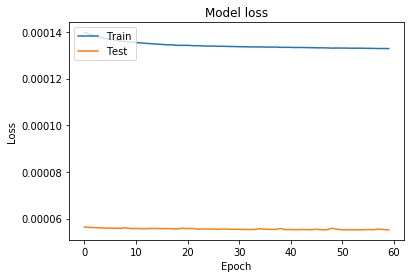

In [70]:
import matplotlib.pyplot as plt


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [71]:
outputs = model.predict(test_data)

In [72]:
print test_data[0]
print test_labels[0]
print outputs[0]

[[ 0.         -0.00055801  0.01599704  0.01041662]
 [ 0.00285213 -0.00148813  0.0112227   0.00706845]
 [ 0.01091266  0.00725445  0.02529763  0.01078872]
 [ 0.01977928  0.01500495  0.03205604  0.02889387]
 [ 0.03131202  0.02653769  0.05915174  0.05543156]
 [ 0.0710565   0.04972721  0.07310264  0.0538194 ]
 [ 0.0396825   0.03428819  0.06448409  0.06380204]
 [ 0.04352681  0.03906252  0.05313735  0.04265876]
 [ 0.05152528  0.03528027  0.05927578  0.04420886]
 [ 0.05102924  0.05022325  0.08804562  0.06764635]
 [ 0.05468745  0.0541915   0.10658484  0.10044641]
 [ 0.11024305  0.0824653   0.11049102  0.09424601]
 [ 0.08500739  0.04458087  0.09027776  0.05102924]
 [ 0.0557416   0.03354417  0.06752232  0.04420886]
 [ 0.04185268  0.00347221  0.04923117  0.01922127]
 [ 0.01773314  0.00824654  0.02628972  0.01630707]
 [ 0.02387157 -0.00241815  0.03168403  0.00551835]
 [ 0.00124006 -0.015687    0.00359624 -0.01196682]
 [-0.02368556 -0.03435025 -0.01705109 -0.03007196]
 [-0.02337552 -0.03918655 -0.02

In [73]:
# primitive policy temporarily in place of a RL policy network

# signal step for our policy network
signals = map(lambda arr: sum(arr) / len(arr),outputs)
# signals = map(lambda arr: arr[0],outputs)
trades = map(lambda signal: 1 if round(signal,4) > 1 else 0,signals)

In [74]:
# one day return
actual = map(lambda arr: arr[0],test_labels)

df = pd.DataFrame({
    'signal':signals,
    'actual': actual,
    'trade':trades,
})

In [75]:
df['entry_success'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 1) else 0,axis=1)
df['entry_failure'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 1) else 0,axis=1)
df['avoid_success'] = df.apply (lambda row: 1 if (row['actual'] < 1.00 and row['trade'] == 0) else 0,axis=1)
df['avoid_failure'] = df.apply (lambda row: 1 if (row['actual'] > 1.00 and row['trade'] == 0) else 0,axis=1)


In [76]:
# primitive policy - replace with a policy network which maximizes reward
def label_success (row):
    return 0 if (row['entry_failure'] == 1 or row['entry_failure'] == 1) else 1

success = df.apply (lambda row: label_success (row),axis=1)
df['success'] = success;
df

actual    signal  trade  entry_success  entry_failure  avoid_success  \
0     0.9963  1.000300      1              0              1              0   
1     1.0029  0.999719      0              0              0              0   
2     1.0081  1.000543      1              1              0              0   
3     1.0090  1.000109      1              1              0              0   
4     1.0119  1.000945      1              1              0              0   
5     1.0428  1.001056      1              1              0              0   
6     0.9673  0.999887      0              0              0              1   
7     1.0040  1.000060      1              1              0              0   
8     1.0084  1.002193      1              1              0              0   
9     0.9995  1.002752      1              0              1              0   
10    1.0039  1.003264      1              1              0              0   
11    1.0624  1.002841      1              1              0              0   
12    0.9724  1.000846      1              0              1              0   
13    0.9690  1.000007      0              0              0              1   
14    0.9855  1.000537      1              0              1              0   
15    0.9754  1.000058      1              0              1              0   
16    1.0063  1.001048      1              1              0              0   
17    0.9773  1.000672      1              0              1              0   
18    0.9757  0.999948      0              0              0              1   
19    1.0003  1.000829      1              1              0              0   
20    1.0088  1.000889      1              1              0              0   
21    1.0033  1.001193      1              1              0              0   
22    1.0105  1.001825      1              1              0              0   
23    0.9670  1.000118      1              0              1              0   
24    1.0071  1.000748      1              1              0              0   
25    0.9616  0.999520      0              0              0              1   
26    1.0175  0.999433      0              0              0              0   
27    1.0073  1.000345      1              1              0              0   
28    0.9967  1.000108      1              0              1              0   
29    1.0322  1.000798      1              1              0              0   
...      ...       ...    ...            ...            ...            ...   
1960  0.9939  0.999566      0              0              0              1   
1961  1.0127  0.999735      0              0              0              0   
1962  0.9977  1.000035      0              0              0              1   
1963  0.9838  0.999437      0              0              0              1   
1964  1.0041  0.999341      0              0              0              0   
1965  0.9859  0.999784      0              0              0              1   
1966  1.0011  0.999705      0              0              0              0   
1967  0.9958  1.000131      1              0              1              0   
1968  0.9959  0.999816      0              0              0              1   
1969  1.0063  0.999650      0              0              0              0   
1970  0.9966  1.000178      1              0              1              0   
1971  0.9988  0.999628      0              0              0              1   
1972  0.9992  0.999916      0              0              0              1   
1973  1.0028  1.000190      1              1              0              0   
1974  0.9999  1.000216      1              0              1              0   
1975  1.0060  1.000659      1              1              0              0   
1976  0.9993  1.000302      1              0              1              0   
1977  1.0001  0.999686      0              0              0              0   
1978  1.0016  0.999521      0              0              0              0   
1979  1.0041  0.999468      

In [77]:
print df['actual'].corr(df['signal'])
print df['actual'].corr(df['trade'])
print df['actual'].corr(df['entry_success'])
print df['actual'].corr(df['success'])


0.009140122235402
0.004438019357029727
0.4471830274316815
0.4648115898011365


In [78]:
df['actual'].describe()

count    1990.000000
mean        1.000404
std         0.009946
min         0.954200
25%         0.996600
50%         1.000600
75%         1.005175
max         1.062400
Name: actual, dtype: float64

In [79]:
df['signal'].describe()

count    1990.000000
mean        1.000470
std         0.000890
min         0.997219
25%         0.999882
50%         1.000428
75%         1.001083
max         1.003569
Name: signal, dtype: float64

In [80]:
NUM_TEST_SAMPLES = len(test_data)
print NUM_TEST_SAMPLES

print '\nPrecision' # optimize for this since we can increase discovery, so long as we find enough trades
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['entry_failure'])) 

print '\nRecall'
print sum(df['entry_success']) * 1.00 / (sum(df['entry_success']) + sum(df['avoid_failure']))

print '\nAccuracy'
print sum(df['entry_success']) * 1.00 / (NUM_TEST_SAMPLES)

print '\nNon-loss events'
print sum(df['success'])
print sum(df['success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nLose trades'
print sum(df['entry_failure'])
print sum(df['entry_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nWin trades'
print sum(df['entry_success'])
print sum(df['entry_success']) / (NUM_TEST_SAMPLES * 1.00)

print '\nMissed opportunities'
print sum(df['avoid_failure'])
print sum(df['avoid_failure']) / (NUM_TEST_SAMPLES * 1.00)

print '\nBullets dodged'
print sum(df['avoid_success'])
print sum(df['avoid_success']) / (NUM_TEST_SAMPLES * 1.00)


1990

Precision
0.549925484352

Recall
0.686511627907

Accuracy
0.370854271357

Non-loss events
1386
0.69648241206

Lose trades
604
0.30351758794

Win trades
738
0.370854271357

Missed opportunities
337
0.169346733668

Bullets dodged
294
0.147738693467


In [81]:
weights, biases = model.layers[0].get_weights()


In [82]:
#list(biases)

In [83]:
today_data = np.array(convert_to_train(SPY.copy(), 0)[0][:1])
today_data

array([[[ 0.        , -0.00071011,  0.00426743, -0.00071011],
        [-0.00711238, -0.00711238, -0.00071011, -0.00071011],
        [-0.00924496, -0.00995733, -0.00426743, -0.00640001],
        [-0.01991465, -0.02062476, -0.00995733, -0.01066743],
        [-0.02418208, -0.02631466, -0.01208991, -0.02346971],
        [-0.02346971, -0.02560455, -0.01777981, -0.02346971],
        [-0.02346971, -0.02702703, -0.02204724, -0.02346971],
        [-0.01635734, -0.01991465, -0.01422475, -0.01991465],
        [-0.01777981, -0.01849218, -0.01351238, -0.01635734],
        [-0.0227596 , -0.02702703, -0.01920229, -0.01920229],
        [-0.01493486, -0.02133713, -0.01493486, -0.02133713],
        [ 0.01066969, -0.01208991,  0.01209217, -0.01208991],
        [ 0.0113798 ,  0.00924722,  0.01493712,  0.01066969],
        [ 0.01209217,  0.        ,  0.02560455,  0.        ],
        [ 0.00853485,  0.00853485,  0.01351464,  0.01209217],
        [ 0.00497979,  0.00355732,  0.00853485,  0.0056899 ],
        

In [84]:
future_prediction = model.predict(today_data)
future_prediction # [1 day prediction, 5 day prediction]

array([[0.9994432]], dtype=float32)